<a href="https://colab.research.google.com/github/adichiara/WPI-DS-541/blob/main/DS_541_HW_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
from numpy import eye as eye
from numpy.linalg import inv as inv
from numpy.linalg import solve as solve
from numpy.linalg import eig as eig
from numpy.linalg import matrix_power
 
from numpy import random
from numpy.random import randn

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
 
import requests
import urllib

In [5]:
# Load data

def load_data():
    urllib.request.urlretrieve('https://s3.amazonaws.com/jrwprojects/fashion_mnist_train_images.npy', 'fashion_mnist_train_images.npy')
    urllib.request.urlretrieve('https://s3.amazonaws.com/jrwprojects/fashion_mnist_test_images.npy', 'fashion_mnist_test_images.npy')
    urllib.request.urlretrieve('https://s3.amazonaws.com/jrwprojects/fashion_mnist_train_labels.npy', 'fashion_mnist_train_labels.npy')
    urllib.request.urlretrieve('https://s3.amazonaws.com/jrwprojects/fashion_mnist_test_labels.npy', 'fashion_mnist_test_labels.npy')

    X_tr = np.reshape(np.load('fashion_mnist_train_images.npy'), (-1, 28*28))
    X_te = np.reshape(np.load('fashion_mnist_test_images.npy'), (-1, 28*28))
    y_tr = np.load('fashion_mnist_train_labels.npy')
    y_te = np.load('fashion_mnist_test_labels.npy')

    return ([X_tr, X_te, y_tr, y_te])



In [6]:

# preprocessing functions

def one_hot_encode_y(y_tr_scalar, y_te_scalar, max_num):
    y_tr = (np.eye(max_num)[y_tr_scalar]).astype(int)
    y_te = (np.eye(max_num)[y_te_scalar]).astype(int)
    return ([y_tr, y_te])


def normalize_inputs(X, max_val):
    X = X/max_val
    return X


In [7]:

# softmax regression functions

def compute_Yhat(X, Y, W, b):
    X = X.T   # orient X as design matrix (m x n) for consistency with formulas
    # compute pre-activation scores
    Z = X.T.dot(W) + b
    # normalize Z
    Z = np.exp(Z) 
    Yhat = Z / np.sum(Z, axis=1, keepdims=True)
    return (Yhat)


def update_weights(X, Y, Yhat, W, L2_alpha, learning_rate):
    n = X.shape[0]   
    X = X.T   # orient X as design matrix (m x n) for consistency with formulas
    # compute gradient of loss function wrt W
    grad_w =  -1/n * (X.dot(Y - Yhat))
    # adjust weights
    L2_grad = (L2_alpha * W)/n
    W_new = W - learning_rate * (grad_w + L2_grad)
    return (W_new)


def update_bias(Y, Yhat, b, learning_rate):
    n = Y.shape[0]   
    # compute gradient of loss function wrt b
    grad_b =  -1/n * np.sum((Yhat - Y), axis=0)
    grad_b = np.atleast_2d(grad_b)
    # adjust bias
    b_new = b - learning_rate * grad_b
    return (b_new)


def crossentropy_loss(Y, Yhat, W, L2_alpha): 
    n = Y.shape[0]
    L2_reg = L2_alpha/(2*n) * np.sum(W.T.dot(W))
    loss = -1/n * np.sum(np.multiply(Y, np.log(Yhat))) + L2_reg
    return (loss)


def crossentropy_loss_unreg(Y, Yhat): 
    n = Y.shape[0]
    loss = -1/n * np.sum(np.multiply(Y, np.log(Yhat)))
    return (loss)


def compute_accuracy(Y, Yhat): 
    correct_matches = np.argmax(Y, axis=1) == np.argmax(Yhat, axis=1)
    accuracy = sum(correct_matches) / Y.shape[0] * 100
    return (accuracy)


In [8]:

# SGD utility functions

def training_validation_splits(X, Y, train_pct):
    split_num = int(np.round(X.shape[0] * train_pct,0))
    all_idx = random.permutation(X.shape[0])
    tr_idx, te_idx = all_idx[:split_num], all_idx[split_num:]
    X_tr, X_val = X[tr_idx,:], X[te_idx,:]
    Y_tr, Y_val = Y[tr_idx], Y[te_idx]
    return ([X_tr, X_val, Y_tr, Y_val])


def randomize_dataset_order(X, Y):
    all_idx = random.permutation(X.shape[0])
    return ([X[all_idx], Y[all_idx]])


def output_live_results(loss, acc, lr, alpha, batch_size, num_epochs, best_params, secs_per_iter, current_iter, max_iterations):
    # just some formatting code for showing results of each hyperparameter combo during grid search
    
    if (loss == best_params['loss']):
      best_loss_label = " * BEST LOSS *"
    else:
      best_loss_label = ""

    print(str(current_iter).zfill(len(str(max_iterations))), "of", max_iterations,
        ' |  loss:', "{:.3f}".format(loss), 
        ' |  best_params_loss:', "{:.3f}".format(best_params['loss']), 
        ' |  accuracy %:', "{:.1f}".format(acc), 
        ' |  best_params_acc%:', "{:.1f}".format(best_params['accuracy']), 
        ' |  learn rate:', "{:.5f}".format(lr),
        ' |  alpha:', "{:.3f}".format(alpha),
        ' |  batch_size:', str(batch_size).zfill(3),
        ' |  epochs:', str(num_epochs).zfill(3),
        ' |  elapsed:', secs_per_iter,
        ' | ', best_loss_label)



In [22]:

# SGD main tuning function

def tune_SGD(X_tr, Y_tr, X_te, Y_te, epoch_list, batch_size_list, L2_alpha_list, learning_rate_list):

    # make train/val/test splits (80% train vs val)
    X_tr, X_val, Y_tr, Y_val = training_validation_splits(X_tr, Y_tr, .8)
    
    # hyperparameter iterative grid search
    max_iterations = (len(epoch_list) * 
                      len(batch_size_list) * 
                      len(L2_alpha_list) * 
                      len(learning_rate_list))
    current_iter = 0
    tuning_results_list = []  # for logging mse validation results of each hyperparameter combo


    tt0 = datetime.datetime.now()
    ttd = datetime.timedelta(seconds=(sum(epoch_list)*len(batch_size_list)*len(L2_alpha_list)*len(learning_rate_list))*.44)
    print("Program start time:  ", tt0.hour-5,":", str(tt0.minute).zfill(2), sep="")
    print("Expected completion: ", (tt0+ttd).hour-5,":", str((tt0+ttd).minute).zfill(2), sep="")
    print("Estimated runtime:  ", ttd)

    for learning_rate in learning_rate_list:
      for L2_alpha in L2_alpha_list:
        for batch_size in batch_size_list:
          print('\n')
          for num_epochs in epoch_list:
            # timestamp for iteration timings
            t0 = datetime.datetime.now()
                  
            # generate initial randomized weights and zero bias
            W = np.random.normal(0, .1, (X_tr.shape[1], 10))
            b = np.zeros(Y_tr.shape[1])
            b = np.atleast_2d(b)

            for epoch in range(0, num_epochs):  
              X_tr, Y_tr = randomize_dataset_order(X_tr, Y_tr)
 
              et_list = []
              et0= datetime.datetime.now()
              for i in range(0, X_tr.shape[0], batch_size):   

                # compute predicted probabilities
                Yhat = compute_Yhat(X_tr[i:i+batch_size,:], Y_tr[i:i+batch_size], W, b) 
       
                # compute gradient for each batch and update weights
                W = update_weights(X_tr[i:i+batch_size,:], Y_tr[i:i+batch_size], 
                                   Yhat, W, 
                                   L2_alpha, learning_rate)
                
                b = update_bias(Y_tr[i:i+batch_size], 
                                Yhat, b, 
                                learning_rate)
              et_list.append(datetime.datetime.now() - et0)

            # timestamp for iteration timings
            print(batch_size, np.mean(et_list))
            t1 = datetime.datetime.now()
            secs_per_iter = (t1-t0).seconds

            # compute loss of trained model on validation set
            Yhat = compute_Yhat(X_val, Y_val, W, b) 

            CEloss_val = crossentropy_loss(Y_val, Yhat, W, L2_alpha)   
            val_accuracy = compute_accuracy(Y_val, Yhat)

            # if the current loss results are the best so far, record these hyperparameters
            if (current_iter>0):  
              if (CEloss_val < best_params['loss']):
                best_params = {'num_epochs': num_epochs,
                              'batch_size': batch_size,
                              'L2_alpha': L2_alpha,
                              'learning_rate': learning_rate,
                              'loss': CEloss_val,
                              'accuracy': val_accuracy} 
            else:
              best_params = {'num_epochs': num_epochs,
                            'batch_size': batch_size,
                            'L2_alpha': L2_alpha,
                            'learning_rate': learning_rate,
                            'loss': CEloss_val,
                            'accuracy': val_accuracy}
                        
            # log tuning results for after analysis
            tuning_results = {'num_epochs': num_epochs,
                              'batch_size': batch_size,
                              'L2_alpha': L2_alpha,
                              'learning_rate': learning_rate,
                              'loss': CEloss_val,
                              'accuracy': val_accuracy,
                              'secs_per_iter': secs_per_iter}  

            tuning_results_list.append(tuning_results)
            current_iter = current_iter + 1

            # output current results of these hyperparameters on validation set 
            output_live_results(CEloss_val, val_accuracy, 
                                learning_rate, L2_alpha, batch_size, num_epochs, 
                                best_params, secs_per_iter, 
                                current_iter, max_iterations)

    #completed testing all hyperparameters - output summary results
    print('\n Hyperparameters tested:', 
          '\n   num_epochs:', epoch_list,
          '\n   batch_size:', batch_size_list,
          '\n   L2_alpha:', L2_alpha_list,
          '\n   learning_rate:', learning_rate_list)
    
    print('\n best_params:', 
          '\n   num_epochs:', best_params['num_epochs'],
          '\n   batch_size:', best_params['batch_size'],
          '\n   L2_alpha:', best_params['L2_alpha'],
          '\n   learning_rate:', best_params['learning_rate'],
          '\n   loss:', best_params['loss'],
          '\n   accuracy:', best_params['accuracy'])

    # train model using best params

    # generate initial randomized weights and zero bias
    W = np.random.normal(0, .1, (X_tr.shape[1], 10))    
    b = np.zeros(Y_tr.shape[1])
    b = np.atleast_2d(b)

    for epoch in range(0, best_params['num_epochs']):  
      X_tr, Y_tr = randomize_dataset_order(X_tr, Y_tr)

      for i in range(0, X_tr.shape[0], best_params['batch_size']):
        # compute predicted probabilities
        Yhat = compute_Yhat(X_tr[i:i+best_params['batch_size'],:], Y_tr[i:i+best_params['batch_size']], W, b) 

        # compute gradient for each batch and update weights
        W = update_weights(X_tr[i:i+best_params['batch_size'],:], 
                           Y_tr[i:i+best_params['batch_size']], 
                           Yhat, W, 
                           best_params['L2_alpha'], best_params['learning_rate'])
        
        b = update_bias(Y_tr[i:i+best_params['batch_size']], 
                        Yhat, b,
                        best_params['learning_rate'])
    
    # compute loss of trained model on test set
    Yhat = compute_Yhat(X_te, Y_te, W, b)
    CEloss_test = crossentropy_loss_unreg(Y_te, Yhat)  
    test_accuracy = compute_accuracy(Y_te, Yhat)

    print("\n loss (test set):", CEloss_test)
    print(" accuracy (test set):", test_accuracy)

    # return tuning results df
    tuning_results_df = pd.DataFrame(tuning_results_list)

    tt1 = datetime.datetime.now()
    print("\nTime of completion: ", tt1.hour-5,":", str(tt1.minute).zfill(2), sep="")
    print(  "Total time to run: ", tt1-tt0)

    return(tuning_results_df)



In [10]:

# Barebones SGD, no tuning

from sklearn.metrics import log_loss

def bare_SGD(X_tr, Y_tr, X_te, Y_te, num_epochs, batch_size, L2_alpha, learning_rate, sd):

    # make train/val/test splits (80% train vs val)
    X_tr, X_val, Y_tr, Y_val = training_validation_splits(X_tr, Y_tr, .8)

    loss_results = []

    # generate initial randomized weights and zero bias
    W = np.random.normal(0, sd, (X_tr.shape[1], 10))
    b = np.zeros(Y_tr.shape[1])
    b = np.atleast_2d(b)

    for epoch in range(0, num_epochs): 
      X_tr, Y_tr = randomize_dataset_order(X_tr, Y_tr)

      for i in range(0, X_tr.shape[0], batch_size):   

        # compute predicted probabilities
        Yhat = compute_Yhat(X_tr[i:i+batch_size,:], Y_tr[i:i+batch_size], W, b) 

        # compute gradient for each batch and update weights
        W = update_weights(X_tr[i:i+batch_size,:], Y_tr[i:i+batch_size], 
                            Yhat, W, 
                            L2_alpha, learning_rate)
        
        b = update_bias(Y_tr[i:i+batch_size], 
                        Yhat, b, 
                        learning_rate)

      # compute loss of trained model on validation set
      Yhat = compute_Yhat(X_val, Y_val, W, b) 
      CEloss_val = crossentropy_loss(Y_val, Yhat, W, L2_alpha)  

      loss_results.append({'epoch': epoch,
                           'loss': CEloss_val})

    # compute loss of trained model on validation set
    Yhat = compute_Yhat(X_val, Y_val, W, b) 

    CEloss_val = crossentropy_loss(Y_val, Yhat, W, L2_alpha)   
    logloss_val = log_loss(Y_val, Yhat)
    val_accuracy = compute_accuracy(Y_val, Yhat)
    
    print("\n loss (validation set):", CEloss_val)
    print(" sklearn log_loss (validation set):", logloss_val)
    print(" accuracy (validation set):", val_accuracy)
    
    # compute loss of trained model on test set
    Yhat = compute_Yhat(X_te, Y_te, W, b)

    CEloss_test = crossentropy_loss_unreg(Y_te, Yhat)  
    logloss_test = log_loss(Y_te, Yhat)
    test_accuracy = compute_accuracy(Y_te, Yhat)

    print("\n loss (test set):", CEloss_test)
    print(" sklearn log_loss (test set):", logloss_test)
    print(" accuracy (test set):", test_accuracy)

    results_df = pd.DataFrame(loss_results)
    return (results_df)


In [11]:
# load data
X_tr, X_te, y_tr_scalar, y_te_scalar = load_data()

# Y class one-hot encoding
Y_tr, Y_te = one_hot_encode_y(y_tr_scalar, y_te_scalar, 10)

# Normalize X pixel values
X_tr = normalize_inputs(X_tr, 255)
X_te = normalize_inputs(X_te, 255)


In [32]:
# softmax SGD with gridsearch

results = tune_SGD(X_tr, Y_tr, X_te, Y_te,
                   epoch_list = [20],
                   batch_size_list = [256],
                   L2_alpha_list = [.05],
                   learning_rate_list = [.001])

display(results)

Program start time:  -4:54
Expected completion: -4:54
Estimated runtime:   0:00:08.800000


256 0:00:00.386884
1 of 1  |  loss: 0.934  |  best_params_loss: 0.934  |  accuracy %: 69.5  |  best_params_acc%: 69.5  |  learn rate: 0.00100  |  alpha: 0.050  |  batch_size: 256  |  epochs: 020  |  elapsed: 8  |   * BEST LOSS *

 Hyperparameters tested: 
   num_epochs: [20] 
   batch_size: [256] 
   L2_alpha: [0.05] 
   learning_rate: [0.001]

 best_params: 
   num_epochs: 20 
   batch_size: 256 
   L2_alpha: 0.05 
   learning_rate: 0.001 
   loss: 0.934212393039162 
   accuracy: 69.525

 loss (test set): 0.9790299176836487
 accuracy (test set): 66.85

Time of completion: -4:54
Total time to run:  0:00:16.967547


,num_epochs,batch_size,L2_alpha,learning_rate,loss,accuracy,secs_per_iter
0,20,256,0.05,0.001,0.934212,69.525,8


In [ ]:

# results = tune_SGD(X_tr, Y_tr, X_te, Y_te,
#                    epoch_list = [200],
#                    batch_size_list = [128, 256],
#                    L2_alpha_list = [.05, .1],
#                    learning_rate_list = [.001, .05])

results = tune_SGD(X_tr, Y_tr, X_te, Y_te,
                   epoch_list = [100],
                   batch_size_list = [128, 256, 512],
                   L2_alpha_list = [.05],
                   learning_rate_list = [.005])
display(results)


 loss (validation set): 0.5774910986807197
 sklearn log_loss (validation set): 0.5774586489949091
 accuracy (validation set): 79.98333333333333

 loss (test set): 0.5973384865375564
 sklearn log_loss (test set): 0.5973384865375564
 accuracy (test set): 79.51


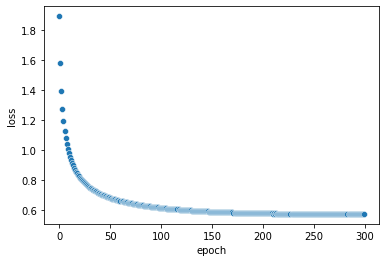

In [144]:
# no tuning

bare_results = bare_SGD(X_tr, Y_tr, X_te, Y_te, 
               num_epochs = 300, 
                batch_size=128, 
                L2_alpha=.01,
                learning_rate=.001, 
                sd=.1)

sns.scatterplot(data=bare_results, x='epoch', y='loss')
plt.show()


15:01


In [ ]:

# debug copies of functions

def debug_compute_Yhat(X, Y, W, b):
    X = X.T   # orient X as design matrix (m x n) for consistency with formulas
    # compute pre-activation scores
    Z = X.T.dot(W) + b
    # normalize Z
    Z = np.exp(Z) 
    Yhat = Z / np.sum(Z, axis=1, keepdims=True)
    return ([Yhat, X])


def debug_update_weights(X, Y, Yhat, W, L2_alpha, learning_rate):
    n = X.shape[0]   
    X = X.T   # orient X as design matrix (m x n) for consistency with formulas
    # compute gradient of loss function wrt W
    grad_w =  -1/n * (X.dot(Y - Yhat))
    # adjust weights
    L2_grad = (L2_alpha * W)/n
    # L2_grad = 0
    # W_new = W - grad_w
    W_new = W - learning_rate * (grad_w + L2_grad)
    return ([W_new, grad_w])


def debug_update_bias(Y, Yhat, b, learning_rate):
    n = Y.shape[0]   
    # compute gradient of loss function wrt b
    grad_b =  -1/n * np.sum((Yhat - Y), axis=0)
    grad_b = np.atleast_2d(grad_b)
    # adjust bias
    b_new = b - learning_rate * grad_b
    return ([b_new, grad_b])


def debug_crossentropy_loss(Y, Yhat, W, L2_alpha): 
    n = Y.shape[0]
    L2_reg = L2_alpha/(2*n) * np.sum(W.T.dot(W))
    loss = -1/n * np.sum(np.multiply(Y, np.log(Yhat))) + L2_reg
    return (loss)


def debug_crossentropy_loss_unreg(Y, Yhat): 
    n = Y.shape[0]
    loss = -1/n * np.sum(np.multiply(Y, np.log(Yhat)))
    return (loss)


def debug_compute_accuracy(Y, Yhat): 
    correct_matches = np.argmax(Y, axis=1) == np.argmax(Yhat, axis=1)
    accuracy = sum(correct_matches) / Y.shape[0] * 100
    return (accuracy)


In [ ]:
# debugging

import cv2

X = X_tr[0:10000]
Y = Y_tr[0:10000]

img = []
fig, axs = plt.subplots(2, 5)
for r in range(1,3):
  for c in range(1,6):
    idx = r*c-1
    image = np.reshape(X[idx], (28, 28))
    img.append(image)
    axs[r-1,c-1].imshow(img[idx], cmap='gray')
plt.show()

learning_rate = .01
alpha = .05

# generate initial randomized weights and zero bias
W = np.random.normal(0, .1, (X.shape[1], 10))
b = np.zeros(Y.shape[1])
b = np.atleast_2d(b)


for i in range(0, 10):

  if (i % 50 == 0):
    img = []
    fig, axs = plt.subplots(2, 5)
    for r in range(1,3):
      for c in range(1,6):
        idx = r*c-1
        image = np.reshape(W[:,idx], (28, 28))
        img.append(image)
        axs[r-1,c-1].imshow(img[idx], cmap='gray')
    plt.show()

  Yhat, Z = debug_compute_Yhat(X, Y, W, b)
  W, grad_w = debug_update_weights(X, Y, Yhat, W, alpha, learning_rate)
  b, grad_b = debug_update_bias(Y, Yhat, b, learning_rate)

  # print("i:", i)
  # # print("max X:", np.max(X))
  # print("Max W:", np.max(W), " Min W:", np.min(W), " Mean W:", np.mean(W))

  # print("Max grad_w:", np.max(grad_w), " Min grad_w:", np.min(grad_w), " mean grad_w:", np.mean(grad_w))
  # print("mean grad_w:", np.mean(np.mean(grad_w, axis=1)))

  # print("Max b:", np.max(b), " Min b:", np.min(b))
  # print("max grad_b:", np.max(grad_b, axis=1))

  # # # print("Sum Yhat:", np.sum(Yhat, axis=1))
  # # print("Mean Y - Yhat:", np.mean(np.mean(Y-Yhat, axis=1)))


  # # # print("Max Z:", np.max(Z), " Min Z:", np.min(Z))
  # # # print("Max Z without b:", np.max(Z_nobias), " Min Z:", np.min(Z_nobias))

  # print("CEloss:", debug_crossentropy_loss(Y, Yhat, W, alpha))
  if (i % 50 == 0):
    print(i, " - Accuracy:", debug_compute_accuracy(Y, Yhat))





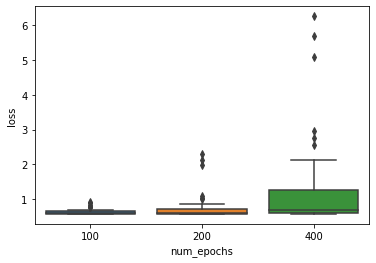

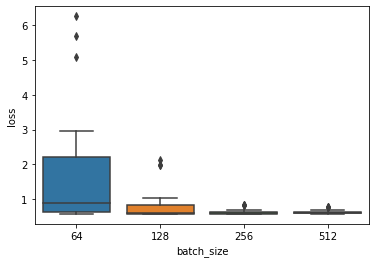

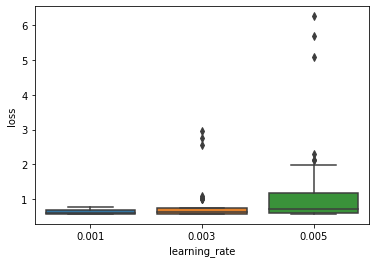

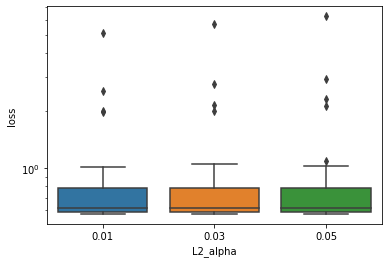

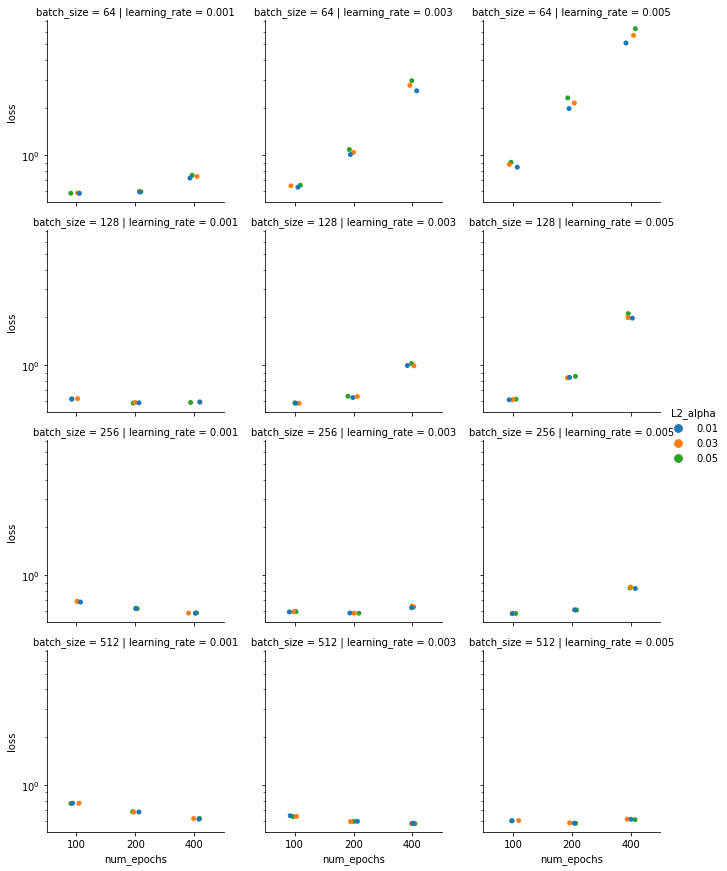

In [54]:

# plots to display tuning results for the hyperparameters tested 


sns.boxplot(data=results, x='num_epochs', y='loss')
# plt.yscale('log')
plt.show()

sns.boxplot(data=results, x='batch_size', y='loss')
# plt.yscale('log')
plt.show()

sns.boxplot(data=results, x='learning_rate', y='loss')
# plt.yscale('log')
plt.show()

sns.boxplot(data=results, x='L2_alpha', y='loss')
plt.yscale('log')
plt.show()

g = sns.catplot(x="num_epochs", y="loss",
                row="batch_size", 
                col='learning_rate',
                hue="L2_alpha", 
                data=results, kind='strip',
                height=3)
plt.yscale('log')
plt.show()
